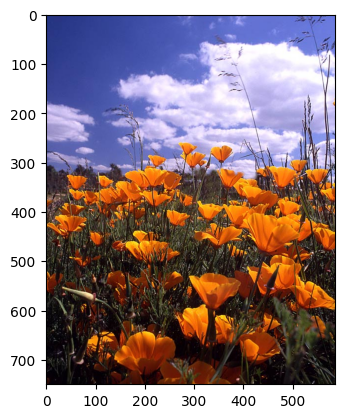

In [2]:
import cv2
import matplotlib.pyplot as plt

# Read the image
img = cv2.imread('imagens/Flores.bmp')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img); 

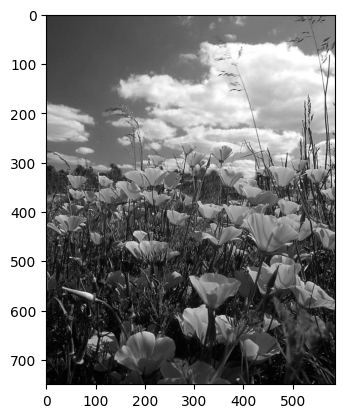

In [3]:
img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
plt.imshow(img, cmap='gray'); 

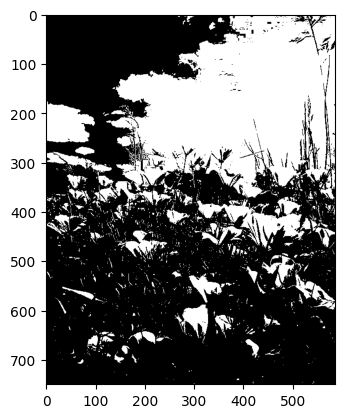

In [4]:
limiar = 120
val, thresh = cv2.threshold(img, limiar, 255, cv2.THRESH_BINARY)
plt.imshow(thresh, cmap='gray'); 

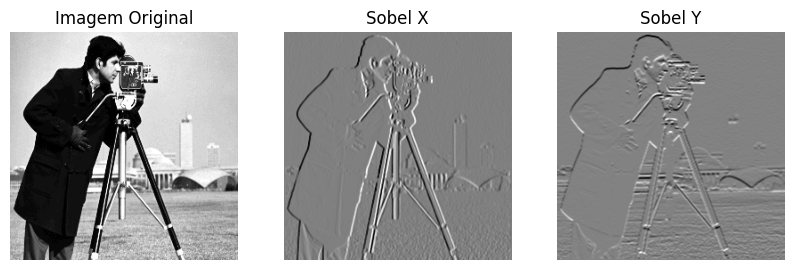

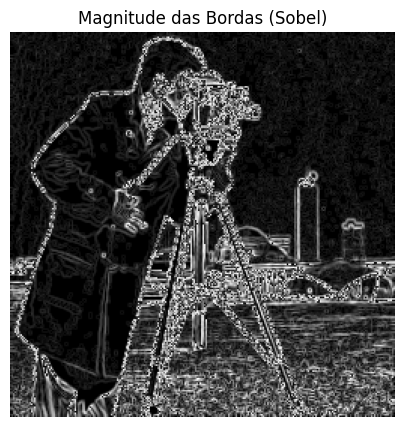

In [5]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Carregar a imagem
img = cv2.imread('imagens/CamMan.bmp', cv2.IMREAD_GRAYSCALE)

# Verificar se a imagem foi carregada corretamente
if img is None:
    print("Erro ao carregar a imagem.")
else:
    # Aplicar o filtro de Sobel para detecção de bordas
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)  # Gradiente em x
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)  # Gradiente em y

    # Calcular a magnitude das bordas
    sobel_magnitude = np.sqrt(sobelx**2 + sobely**2)
    sobel_magnitude = np.uint8(np.absolute(sobel_magnitude))

    # Exibir a imagem original e as bordas detectadas
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(img, cmap='gray')
    plt.title('Imagem Original')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(sobelx, cmap='gray')
    plt.title('Sobel X')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(sobely, cmap='gray')
    plt.title('Sobel Y')
    plt.axis('off')

    plt.figure(figsize=(5, 5))
    plt.imshow(sobel_magnitude, cmap='gray')
    plt.title('Magnitude das Bordas (Sobel)')
    plt.axis('off')

    plt.show()


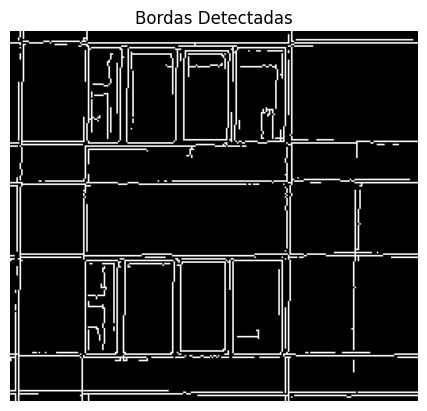

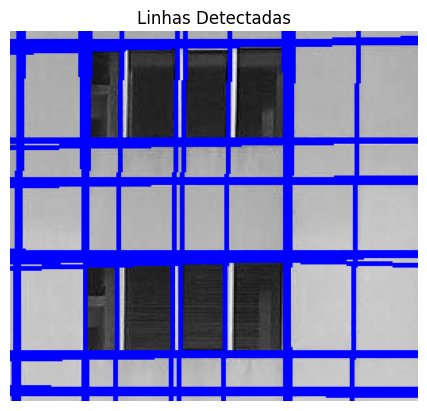

In [14]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math

# Função para mostrar a imagem usando matplotlib
def mostrar_imagem(img, titulo="Imagem"):
    plt.imshow(img, cmap='gray')
    plt.title(titulo)
    plt.axis('off')
    plt.show()

# Função para converter imagem RGB para escala de cinza
def rgb_para_cinza(rgb):
    return np.dot(rgb[..., :3], [0.299, 0.587, 0.114]).astype(np.uint8)

# Etapa 1: Obtenha uma imagem binária com as bordas da imagem
def obter_bordas(caminho_img, limiar_baixo=50, limiar_alto=150):
    img = cv2.imread(caminho_img)
    if img.ndim == 3:
        img = rgb_para_cinza(img)
    bordas = cv2.Canny(img, limiar_baixo, limiar_alto)
    return bordas

# Etapa 2: Defina como o plano \rho\theta será dividido (estrutura da matriz acumuladora)
def definir_acumuladora(img, passo_angulo=1):
    thetas = np.deg2rad(np.arange(-90.0, 90.0, passo_angulo))
    largura, altura = img.shape
    comprimento_diag = int(round(math.sqrt(largura ** 2 + altura ** 2)))
    rhos = np.linspace(-comprimento_diag, comprimento_diag, comprimento_diag * 2)
    acumuladora = np.zeros((2 * comprimento_diag, len(thetas)), dtype=np.uint8)
    return acumuladora, thetas, rhos

# Etapa 3: Aplique a parametrização aos pontos da imagem das bordas, atualizando a matriz acumuladora
def aplicar_parametrizacao(img_bordas, acumuladora, thetas, rhos):
    largura, altura = img_bordas.shape
    comprimento_diag = len(rhos) // 2
    cos_t = np.cos(thetas)
    sin_t = np.sin(thetas)
    y_idxs, x_idxs = np.nonzero(img_bordas)

    for i in range(len(x_idxs)):
        x = x_idxs[i]
        y = y_idxs[i]
        for t_idx in range(len(thetas)):
            rho = int(round(x * cos_t[t_idx] + y * sin_t[t_idx])) + comprimento_diag
            acumuladora[rho, t_idx] += 1

    return acumuladora

# Etapa 4: Examine a matriz acumuladora em busca de células com valores elevados
def encontrar_linhas_acumuladora(acumuladora, thetas, rhos, limiar):
    linhas = []
    for r_idx in range(acumuladora.shape[0]):
        for t_idx in range(acumuladora.shape[1]):
            if acumuladora[r_idx, t_idx] > limiar:
                rho = rhos[r_idx]
                theta = thetas[t_idx]
                linhas.append((rho, theta))
    return linhas

# Etapa 5: Examine a relação (principalmente as de continuidade) entre os pixels oriundos das células escolhidas
def desenhar_linhas(img, linhas):
    img_linhas = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    comprimento_diag = int(round(math.sqrt(img.shape[0] ** 2 + img.shape[1] ** 2)))
    for rho, theta in linhas:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + comprimento_diag * (-b))
        y1 = int(y0 + comprimento_diag * (a))
        x2 = int(x0 - comprimento_diag * (-b))
        y2 = int(y0 - comprimento_diag * (a))
        cv2.line(img_linhas, (x1, y1), (x2, y2), (0, 0, 255), 2)
    return img_linhas

if __name__ == '__main__':
    caminho_img = 'imagens/janela.bmp'
    limiar_valores_elevados = 100  # Defina o limiar aqui

    # Etapa 1: Obtenha uma imagem binária com as bordas da imagem
    bordas = obter_bordas(caminho_img)
    mostrar_imagem(bordas, "Bordas Detectadas")

    # Etapa 2: Defina como o plano \rho\theta será dividido
    acumuladora, thetas, rhos = definir_acumuladora(bordas)

    # Etapa 3: Aplique a parametrização aos pontos da imagem das bordas, atualizando a matriz acumuladora
    acumuladora = aplicar_parametrizacao(bordas, acumuladora, thetas, rhos)

    # Etapa 4: Examine a matriz acumuladora em busca de células com valores elevados
    linhas_detectadas = encontrar_linhas_acumuladora(acumuladora, thetas, rhos, limiar=limiar_valores_elevados)

    # Etapa 5: Examine a relação entre os pixels oriundos das células escolhidas
    img_original = cv2.imread(caminho_img, cv2.IMREAD_GRAYSCALE)
    img_com_linhas = desenhar_linhas(img_original, linhas_detectadas)
    mostrar_imagem(img_com_linhas, "Linhas Detectadas")
